# Non-Adiabatic Particle In A Box

## Import Necessary Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter #PillowWriter
from scipy.linalg import eigh
#from scipy.io import wavfile # for sound waves
from IPython.display import Audio # for sound waves

## Define Constants and Parameters

## Plotting Energy Levels

In [2]:
%matplotlib inline

In [3]:
# Atomic base units:
bhorradius = 1  # length
hbar = 1  # in atomic units
me = 1  # mass of electron in atomic units
Hartree = 1  # energy

# Convenient units in terms of atomic units:
angs = 1 / 0.529177  # in atomic units
fs = 1 / (1e15 * 2.4188843265864e-17)  # in atomic units
eV = 1 / 27.211386245988  # eV in atomic units (Hartree)

# Define parameters
pi = math.pi


In [4]:
%matplotlib widget

In [6]:
# === Define Box Parameters === #

mu = 1 * me
dr = 0.1 * angs
r = np.arange(-25 * angs, 30 * angs, dr)

E0 = 2 * eV
r0L = 20 * angs
r0R = 0 * angs
# === END === #

In [7]:
# === Define Kinetic Energy and Potential Energy Equations (Do Not Change) === #

# Kinetic energy prefactor
kinEPrefactor = -(1 / (dr ** 2)) * hbar ** 2 / (2 * mu)

# Potential well
PES = -E0 * (1 - np.heaviside(r - r0R, 0.5)) * np.heaviside(r + r0L, 0.5)

# Hamiltonian
H = np.diag(-2 * kinEPrefactor + PES) + np.diag(kinEPrefactor * np.ones(len(r) - 1), 1) + np.diag(kinEPrefactor * np.ones(len(r) - 1), -1)
# === END === #

# === Solve Hamiltonian for Eigenvalues: Energies and Wave Function (Psig) (Do Not Change) === #
# Solve Hamiltonian for eigenvals
Energies, wavefuncs = eigh(H)
Eg = np.diag(Energies)
Psig = wavefuncs[:, 0]
# === END === #

In [8]:
# === Define Expanding Box === #
# Expanding Box
dt = 0.01 * fs

# For fast expansion, 
velocity = 4.5 * angs / fs

expansiondistance = 20 * angs
tfinal = ( expansiondistance) / velocity
#t = np.arange(0, tfinal + 100 * fs, dt)
t = np.arange(0, tfinal + 5 * fs, dt)
# === END === #

Psi = Psig.copy()

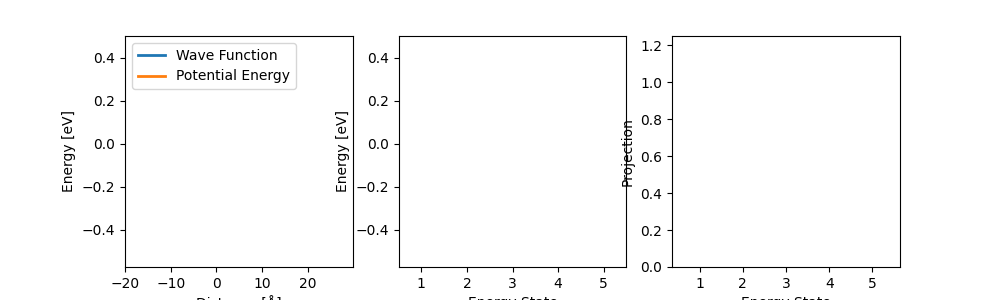

In [14]:
# === Initialize plot (Do Not Change) === #
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].set_xlim(r[0] / angs + 5, r[-1] / angs)
ax[0].set_ylim(-E0-0.5, 0.5)
wave_plot, = ax[0].plot([], [], lw=2, label="Wave Function")
pes_plot, = ax[0].plot([], [], lw=2, label="Potential Energy")


ax[0].set(ylabel="Energy [eV]", xlabel="Distance [Å]")
ax[2].set(ylabel="Projection", xlabel="Energy State")
ax[1].set(ylabel="Energy [eV]", xlabel="Energy State")

ax[0].legend(loc="upper left")


bar_positions = np.arange(1, 6)# 11)
start_vals = np.zeros_like(bar_positions)
bars = ax[2].bar(bar_positions, start_vals, label="Projections")
ax[2].set_xticks([1, 2, 3, 4, 5]) #, 6, 7, 8, 9, 10])
ax[2].set_ylim([0, 1.25])

energies = ax[1].scatter([], [], s=20, label="Energies")
ax[1].set_xlim([0.5, 5.5])
ax[1].set_ylim([-E0-0.5, 0.5])

def init():
    wave_plot.set_data([], [])
    pes_plot.set_data([], [])
    for bar, val in zip(bars, start_vals):  
        bar.set_height(start_vals)
#    energies.set_offsets(np.empty((1, 2)))
    energies.set_offsets(np.empty((0, 2)))  # Initialize with empty offsets
    return wave_plot, pes_plot, bars, energies
# === END === #

In [15]:
#PES = -E0

# === Define Plot Updating Using Runge-Kutta 4th Order For Wave Function === #
def update_plot(j):
    global Psi, PES
    if t[j] < tfinal:
        PES = -E0 * (1 - np.heaviside(r - (r0R + velocity * t[j]) , 0.5)) * np.heaviside(r + r0L , 0.5)
    H = np.diag(-2 * kinEPrefactor + PES) + np.diag(kinEPrefactor * np.ones(len(r) - 1), 1) + np.diag(kinEPrefactor * np.ones(len(r) - 1), -1)

    # Runge-Kutta 4th order
    k1 = (-1j / hbar) * H @ Psi #Euler
    k2 = (-1j / hbar) * H @ (Psi + (dt / 2) * k1) #Trapezoidal Rule/ Heun's Method (Predictor-Corrector Method)
    k3 = (-1j / hbar) * H @ (Psi + (dt / 2) * k2)
    k4 = (-1j / hbar) * H @ (Psi + dt * k3)

    Psi = Psi + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    
    ax[0].text(10, 0.25, f"Velocity={speed_coeff}")

    if j % 10 == 0:
        # Update plots
        functoplot = 25 * (np.abs(Psi) ** 2) + Eg[0] / eV - well_depth
        wave_plot.set_data(r / angs, functoplot)
        pes_plot.set_data(r / angs, PES / eV)

        current_t = t[j]  / fs
        fig.suptitle(f"Time: {current_t:.2f} fs")
        
        Eigenvals, Eigenfuncs = np.linalg.eigh(H)

        Energies = Eigenvals / eV
        print(Energies.shape)
    
        projections = np.zeros(5)
        for k in range(len(projections)):
            projections[k] = np.abs(np.sum(Psi * Eigenfuncs[:, k]))


        for bar, height in zip(bars, projections):
            bar.set_height(height)

        # Generate Sound: WORK IN PROGRESS!
            
        #tottime = 0.8   
        #samfreq = 40000 
        #tsound = np.linspace(0, tottime, int(samfreq * tottime))
        #eVtoSound = 280000  
        #soundfunction = np.zeros(len(tsound))

        #offsets = []
        #sizes = []
        
        for k in range(len(projections)):
         #   soundv = 800 + (Energies[k] + 0.1447) * eVtoSound
          #  if projections[k] < 0.02:
          #      projections[k] = 0

          #  soundfunction += projections[k] * np.cos(2 * np.pi * soundv * tsound)
            
          #  offsets.append([k + 1, Energies[k]])
          #  size = int(projections[k]*100)
          #  sizes.append(size)
            
        energies.set_sizes(sizes)

        offsets = np.array(offsets)

        energies.set_offsets(offsets)
        
        #soundfunction = soundfunction / np.max(soundfunction)

        # Save sound to .wav file for each 10 timesteps
#        wavfile.write(f'output_eigh{j}.wav', samfreq, soundfunction.astype(np.float32)) 
        
    return wave_plot, pes_plot, bars, energies
# === END === #

# === Run The Simulation === #
ani = FuncAnimation(fig, update_plot, init_func=init, frames=len(t), interval=2, blit=True, repeat=False)

plt.tight_layout()

plt.show()


# === Save The Animation (Will Not Plot To Notebook If Activated) ===#
#ani.save('name.mp4', writer=FFMpegWriter(fps=60))
# === END === #

IndentationError: expected an indented block after 'for' statement on line 54 (3467039955.py, line 65)